In [1]:
import os
import theano
import calendar
from theano import *
import theano.tensor as tt
import scipy.stats as stats
from theano.compile.ops import as_op
import matplotlib.pyplot as plt
from argparse import Namespace
import pandas as pd
import numpy as np
import pymc3 as pm
import argparse
import pickle
import json
import math
import sys  

sys.path.insert(0, '/Users/Yannis/code/fibe2-mini-project/models')
from NonLinearReservoirModel import NonLinearReservoirModel as NLRM

# Import data

In [2]:
# Get current working directory and project root directory
cwd = os.getcwd()
rd = os.path.join(cwd.split('fibe2-mini-project/', 1)[0])
if not rd.endswith('fibe2-mini-project'):
    rd = os.path.join(cwd.split('fibe2-mini-project/', 1)[0],'fibe2-mini-project')

In [3]:
model0data = pd.read_csv(os.path.join(rd,'data','output','simulations','linear_reservoir_simulation_monthly.csv'))
model2data = pd.read_csv(os.path.join(rd,'data','output','simulations','hymod_simulation_monthly.csv'))

model1data = pd.read_csv(os.path.join(rd,'data','output','simulations','nonlinear_reservoir_simulation_monthly.csv'))
model1data['date'] = pd.to_datetime(model1data['date'])
model1data['time_label'] = model1data['date'].apply(lambda x: f'{calendar.month_abbr[x.month]}-{str(x.year)[-2:]}')


# Store net net_rainfall
nr = model1data['net_rainfall'].values.tolist()
n = len(nr)

with open(os.path.join(rd,'data','output','simulations/nonlinear_reservoir_simulation_monthly_true_parameters.json'), 'r') as f:
    nlrm_true_params = json.load(f)
nlrm_true_args = Namespace(**nlrm_true_params)

with open(os.path.join(rd,'data','output','posterior_samples/nonlinear_reservoir_samples_monthly_priors.json'), 'r') as f:
    nlrm_priors = json.load(f)
nlrm_priors_args = Namespace(**nlrm_priors)

In [4]:
# Instantiate linear reservoir statistical model
nlrm = NLRM(nr,nlrm_true_args)

@as_op(itypes=[tt.dscalar,tt.dscalar], otypes=[tt.dmatrix])
def th_forward_model(param1,param2):
    parameter_list = [param1,param2]

    th_states = nlrm.simulate(parameter_list,nlrm_true_args.fatconv)
    return th_states

In [5]:
# Path to files
csv_file = os.path.join(rd,'data','output','posterior_samples/linear_reservoir_samples.csv')

NLStrace_NLSdata_file = os.path.join(rd,'data','output','posterior_samples/nonlinear_reservoir_samples_monthly_NLRMdata_trace.pickle')
NLSmodel_NLSdata_file = os.path.join(rd,'data','output','posterior_samples/nonlinear_reservoir_samples_monthly_NLRMdata_model.pickle')

# LRMtrace_HYMODdata_file = os.path.join(rd,'data','output','posterior_samples/linear_reservoir_samples_monthly_HYMODdata_trace.pickle')
# LRMmodel_HYMODdata_file = os.path.join(rd,'data','output','posterior_samples/linear_reservoir_samples_monthly_HYMODdata_model.pickle')

In [6]:
# Read files
# results = pd.read_csv(csv_file)

NLStrace_NLSdata = open(NLStrace_NLSdata_file,"rb")
NLSmodel_NLSdata = open(NLSmodel_NLSdata_file,"rb")
NLStrace_NLSdata = pickle.load(NLStrace_NLSdata)
NLSmodel_NLSdata = pickle.load(NLSmodel_NLSdata)

# LRMtrace_HYMODdata = open(LRMtrace_HYMODdata_file,"rb")
# LRMmodel_HYMODdata = open(LRMmodel_HYMODdata_file,"rb")
# LRMtrace_HYMODdata = pickle.load(LRMtrace_HYMODdata)
# LRMmodel_HYMODdata = pickle.load(LRMmodel_HYMODdata)

traces = {"NLS":NLStrace_NLSdata}#,"HYMOD":LRMtrace_HYMODdata}
models = {"NLS":NLSmodel_NLSdata}#,"HYMOD":LRMmodel_HYMODdata}

In [7]:
keys = ['current_model','true_model','parameter','-log_marginal_likelihood','mean', 'sd', 'mc_error', 'hpd_2.5', 'hpd_97.5']
results = pd.DataFrame(columns=keys)
for mi in ['NLS']:#,'HYMOD']:
    vals = np.append(np.array(['NLS',mi,'k',models[mi].marginal_likelihood]),pm.summary(traces[mi], ['k']).values[0])
    results = results.append(dict(zip(keys, vals)),ignore_index=True)
    vals = np.append(np.array(['NLS',mi,'sigma',models[mi].marginal_likelihood]),pm.summary(traces[mi], ['sigma']).values[0])
    results = results.append(dict(zip(keys, vals)),ignore_index=True)

In [8]:
results

,current_model,true_model,parameter,-log_marginal_likelihood,mean,sd,mc_error,hpd_2.5,hpd_97.5
0,NLS,NLS,k,3.271772409403834e-11,1.1272378662120077,0.057434821408375684,0.0012471988969599526,1.0157225735742608,1.2397490381112686
1,NLS,NLS,sigma,3.271772409403834e-11,0.5049393834046113,0.07449538839016885,0.0014972984340508428,0.36271474409282123,0.6493440165965267


# Parameter posteriors

In [9]:
colors = ['b','g','r','c','m','y']

In [10]:
scalefactor = 500

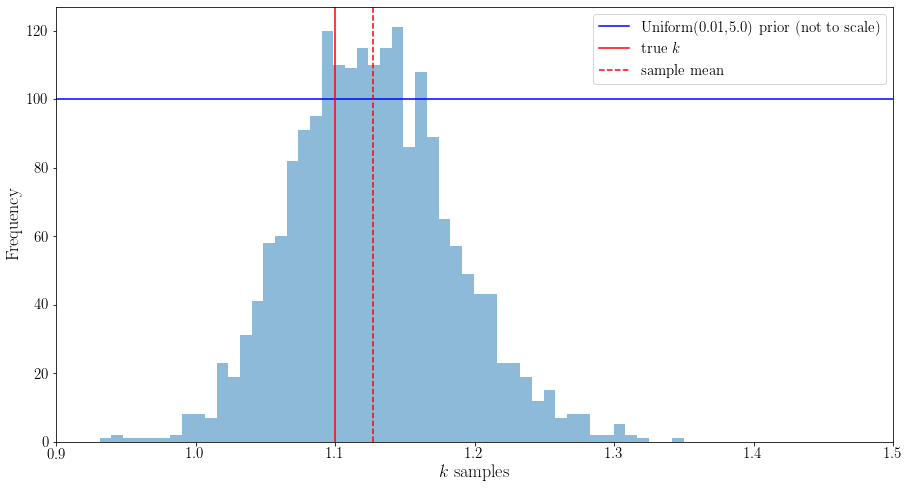

In [15]:
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

x = np.linspace(0, nlrm_priors_args.kmax*11/10, 200) 
y1 = stats.uniform.pdf(x, loc=0.01, scale=nlrm_priors_args.kmax)

plt.hist(NLStrace_NLSdata['k'],bins=50,alpha=0.5)
plt.plot(x, y1*scalefactor, label=(f'Uniform(0.01,{nlrm_priors_args.kmax}) prior (not to scale)'),color=colors[0]) 
plt.xlabel(r'$k$ samples',fontsize=18)
plt.ylabel(r'Frequency',fontsize=18)
plt.axvline(x=nlrm_true_args.k,color='r',label=r'true $k$')
plt.axvline(x=np.mean(NLStrace_NLSdata['k']),color='r',linestyle='--',label='sample mean')
plt.legend(prop={'size': 15})
plt.xlim([0.9,1.5])
plt.savefig(os.path.join(rd,'data','figures','nls_k_hist.png'))
plt.show()

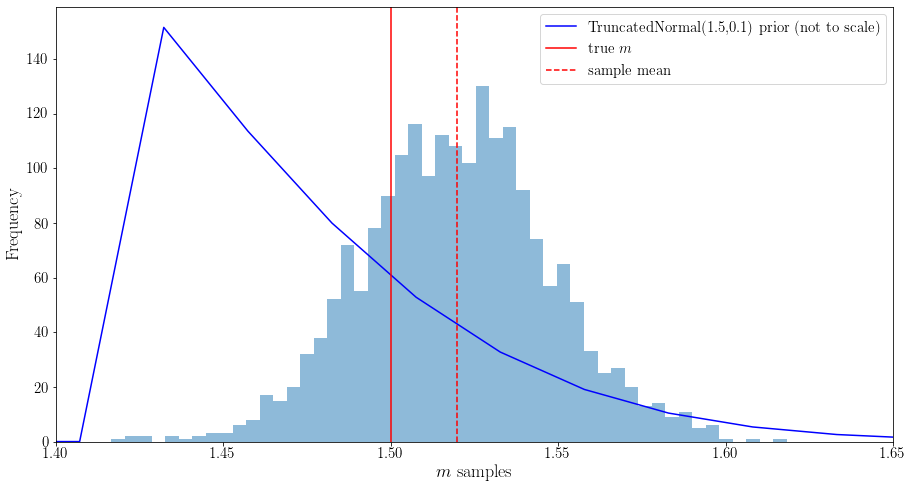

In [18]:
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

x = np.linspace(0, 5, 200) 
y1 = stats.truncnorm.pdf(x, a=1.01,b=100,loc=1.33,scale=nlrm_priors_args.msd)

plt.hist(NLStrace_NLSdata['m'],bins=50,alpha=0.5)
plt.plot(x, y1*10, label=(f'TruncatedNormal({nlrm_priors_args.mmu},{nlrm_priors_args.msd}) prior (not to scale)'),color=colors[0]) 
plt.xlabel(r'$m$ samples',fontsize=18)
plt.ylabel(r'Frequency',fontsize=18)
plt.xlim([1.1,2.1])
plt.axvline(x=nlrm_true_args.m,color='r',label=r'true $m$')
plt.axvline(x=np.mean(NLStrace_NLSdata['m']),color='r',linestyle='--',label='sample mean')
plt.xlim([1.4,1.65])
plt.legend(prop={'size': 15})

plt.savefig(os.path.join(rd,'data','figures','nls_m_hist.png'))
plt.show()

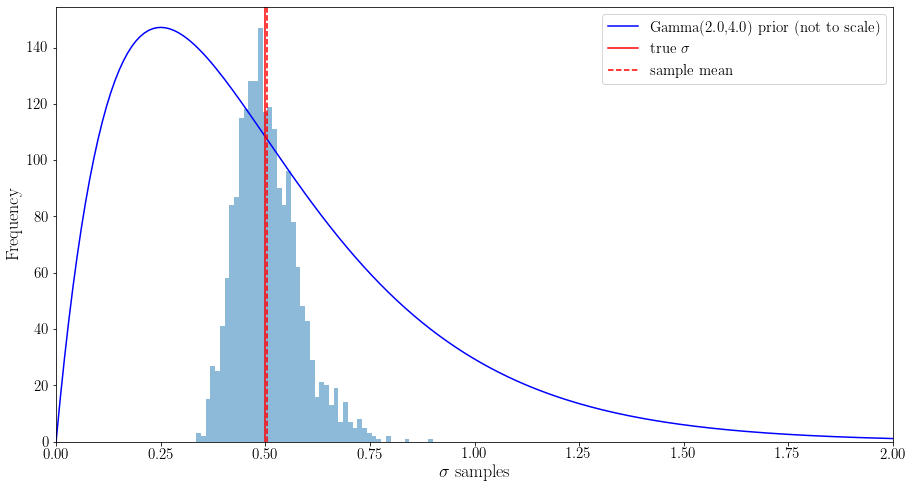

In [138]:
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

x = np.linspace(0, 2, 200) 
y1 = stats.gamma.pdf(x, a=nlrm_priors_args.alpha, scale=1/nlrm_priors_args.beta)

plt.hist(NLStrace_NLSdata['sigma'],bins=50,alpha=0.5)
plt.plot(x, y1*100, label=(f'Gamma({nlrm_priors_args.alpha},{nlrm_priors_args.beta}) prior (not to scale)'),color=colors[0]) 
plt.xlabel(r'$\sigma$ samples',fontsize=18)
plt.ylabel(r'Frequency',fontsize=18)
plt.axvline(x=nlrm_true_args.sigma,color='r',label=r'true $\sigma$')
plt.axvline(x=np.mean(NLStrace_NLSdata['sigma']),color='r',linestyle='--',label='sample mean')
plt.xlim([0,2])
plt.legend(prop={'size': 15})

plt.savefig(os.path.join(rd,'data','figures','nls_sigma_hist.png'))
plt.show()

In [ ]:
# with LRMmodel_LRMdata:
#     pm.traceplot(LRMtrace_LRMdata);

In [ ]:
# _ = pm.plot_posterior(LRMtrace_LRMdata,varnames=['k','sigma'])

# Posterior predictive

In [12]:
# Choose number of posterior samples
npostsamples = 1000

In [13]:
nls_ppc_samples = pm.sample_posterior_predictive(NLStrace_NLSdata, samples=npostsamples, model=NLSmodel_NLSdata)['Q_obs']
nls_mean_ppc = nls_ppc_samples.mean(axis=0)
nls_CriL_ppc = np.percentile(nls_ppc_samples,q=2.5,axis=0)
nls_CriU_ppc = np.percentile(nls_ppc_samples,q=97.5,axis=0)

100%|██████████| 1000/1000 [01:42<00:00,  9.78it/s]


In [14]:
t1,t2 = 0,25
factor = 1.2

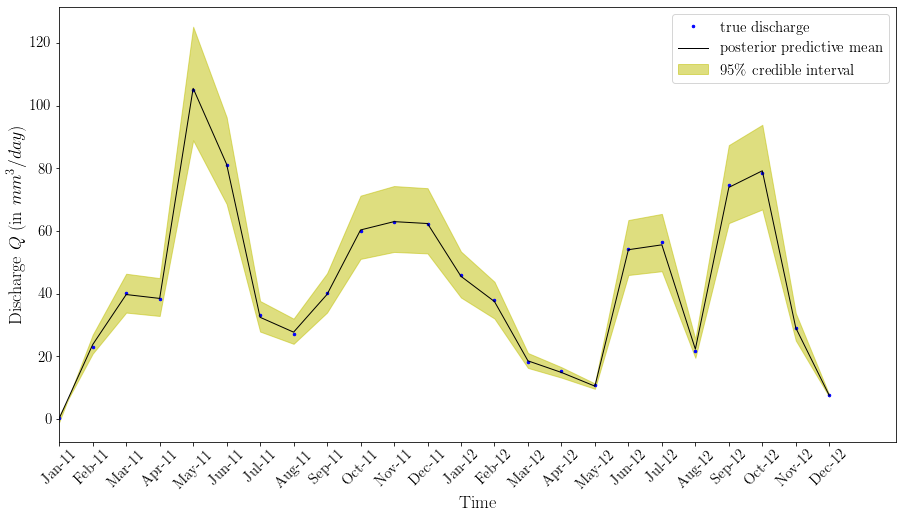

In [15]:
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=15)

plt.plot(model1data['time'][t1:t2],model1data['discharge'][t1:t2],'o', color='b', lw=1, ms=2.5,label=r'true discharge')
plt.plot(model1data['time'][t1:t2],nls_mean_ppc[t1:t2,0], color='k', lw=1,label=r'posterior predictive mean')
plt.fill_between(model1data['time'][t1:t2], factor*nls_CriL_ppc[t1:t2,0], (1/factor)*nls_CriU_ppc[t1:t2,0],color='y',alpha=0.5,label=r'95\% credible interval')
plt.xlim([t1,t2])
plt.ylabel(r'Discharge $Q$ (in $mm^3/day$)', fontsize=18)
plt.xlabel(r'Time',fontsize=18)
plt.xticks(ticks=model1data['time'][t1:t2],labels=model1data['time_label'][t1:t2],rotation=45)
plt.legend()

plt.savefig(os.path.join(rd,'data','figures/nls_predictions.png'))
plt.show()